# Deep Q-Learning and its application for stock trading

## Produced by:
- Anton Chumakov
- Clement Garancini
- Jesse Giroux

In [2]:
import os

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [3]:
# Import libraries
from IPython.display import SVG, display
import numpy as np
import random
import pandas as pd
from abc import abstractmethod
from typing import Tuple
import yfinance as yf
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

# Introduction

Explain...

# Part 1. **Simplified discrete** stock trading problem
---
---

Explain...

## 1.1 Markov Decision Process (MDP)

---

MDP introduction...

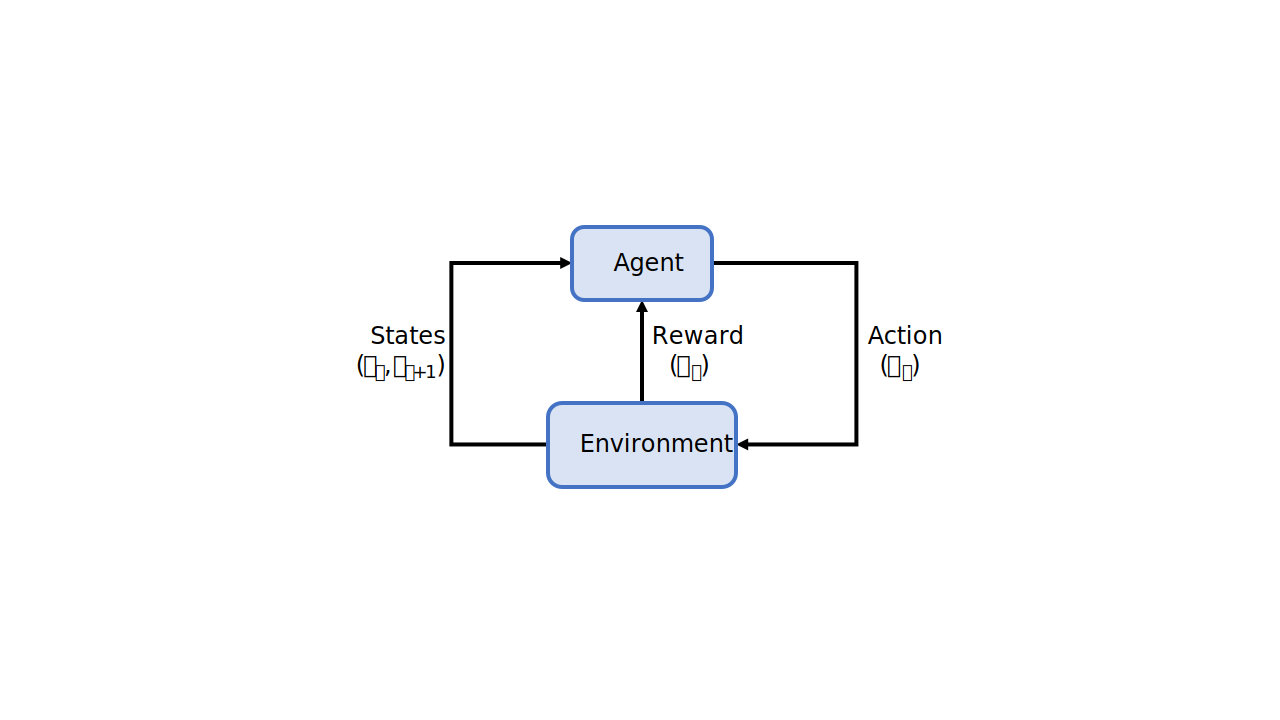

In [2]:
display(SVG(url="https://drive.google.com/uc?id=1vEy83A9RqWPIKc1eTgXue0zQYFxFHwPV"))

### States (S)

Explain...

### Actions (A)

Explain...

### Rewards (R)

Explain...

## 1.2 Q-Learning
---

Q-Learning introduction...

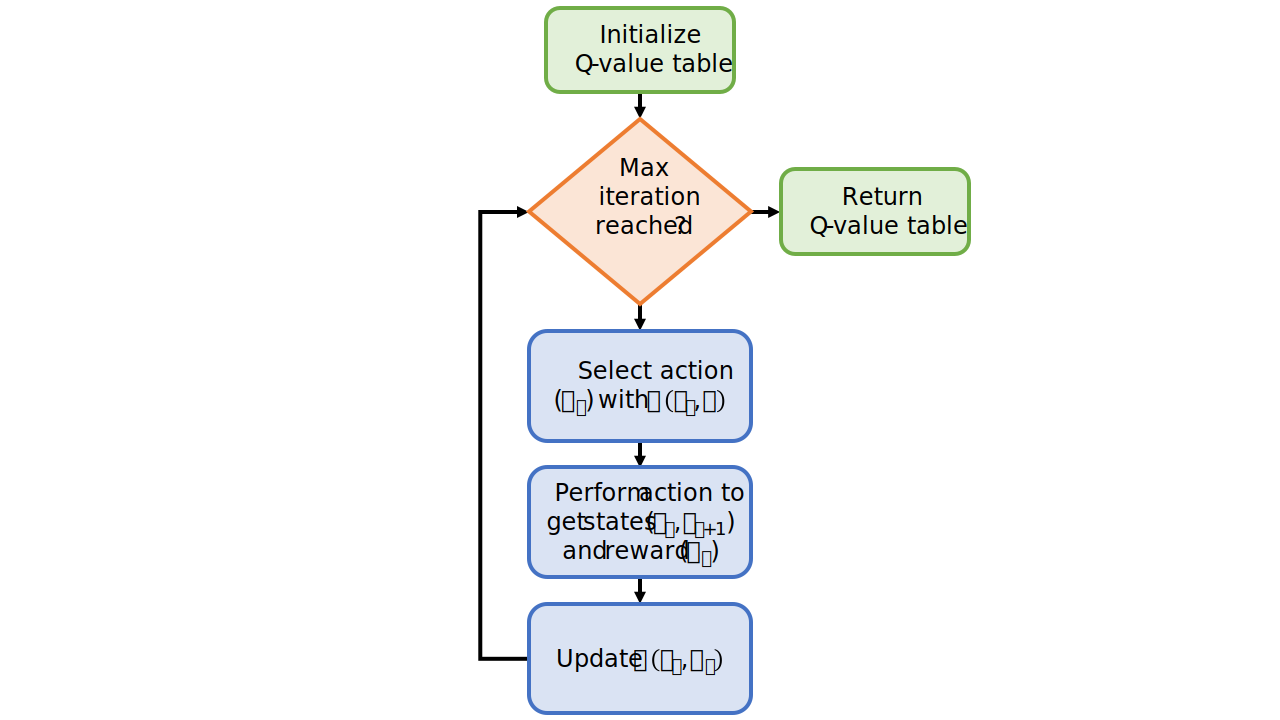

In [3]:
display(SVG(url="https://drive.google.com/uc?id=1GnWrILTMWa5YU_tIjd3GuF5GiwZA4O1L"))

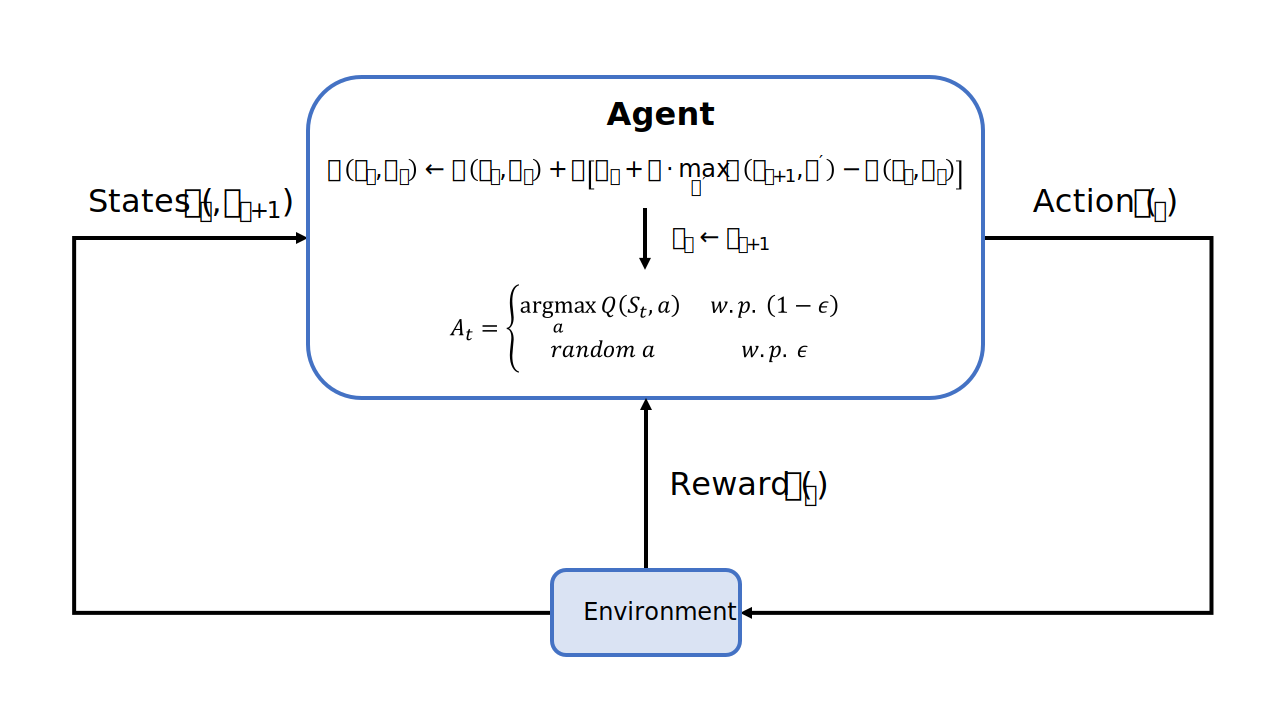

In [4]:
display(SVG(url="https://drive.google.com/uc?id=15u_iFwGZ8F2-r10OjjcoUDZ1YX6R8qkh"))

### Initialize Q-value table

Explain...

### Select an action ($A_{t}$) with $Q(S_{t}, a)$

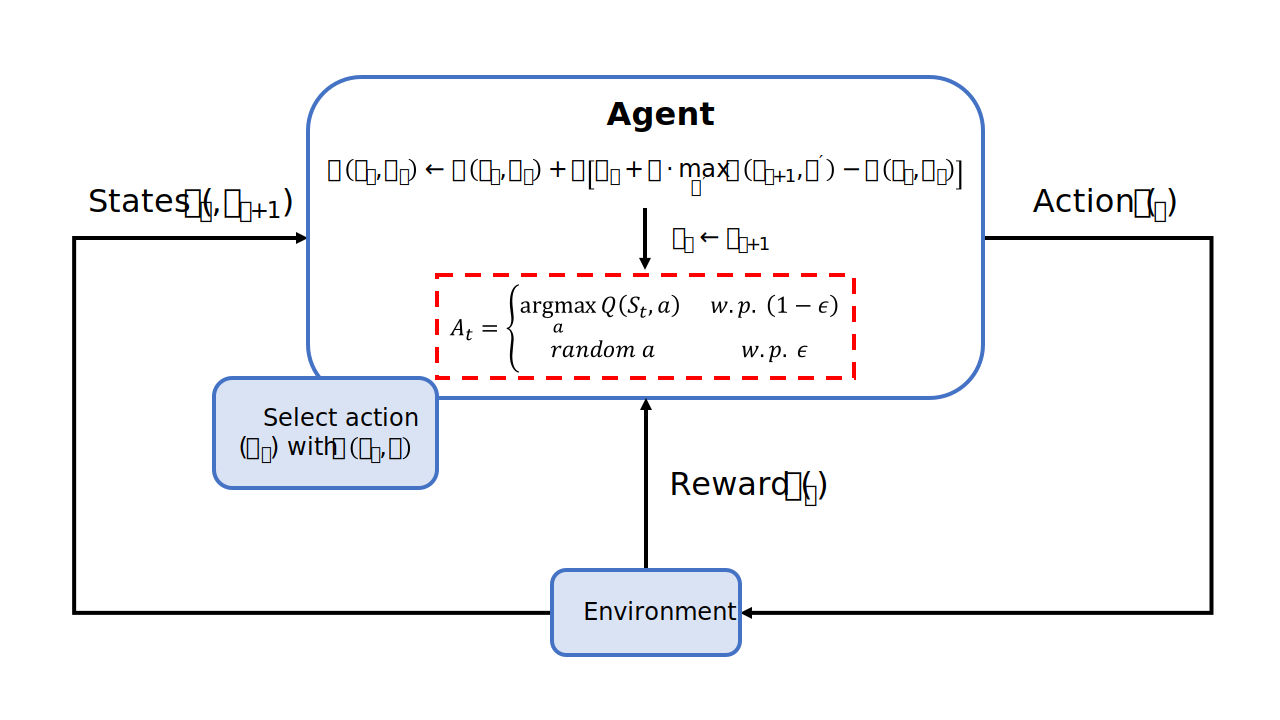

In [5]:
display(SVG(url="https://drive.google.com/uc?id=1cZlF1HessLf5_goCwAxM9V_KSaB2pBFY"))

Explain...

### Perform an action to get states $(S_{t}, S_{t+1})$ and reward $(R_{t})$

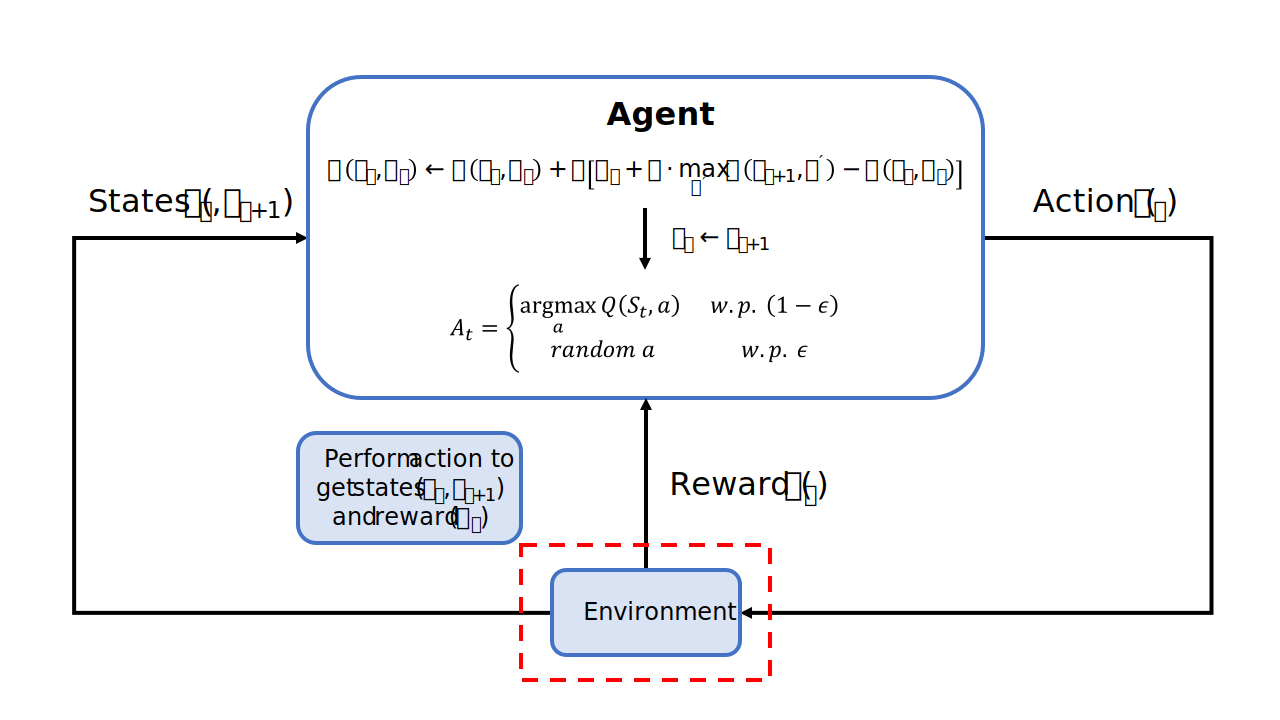

In [6]:
display(SVG(url="https://drive.google.com/uc?id=1a56GNy52ddeAmUUp8HNVl1RkEV1pXXlW"))

Explain...

### Update $Q(S_{t}, A_{t})$

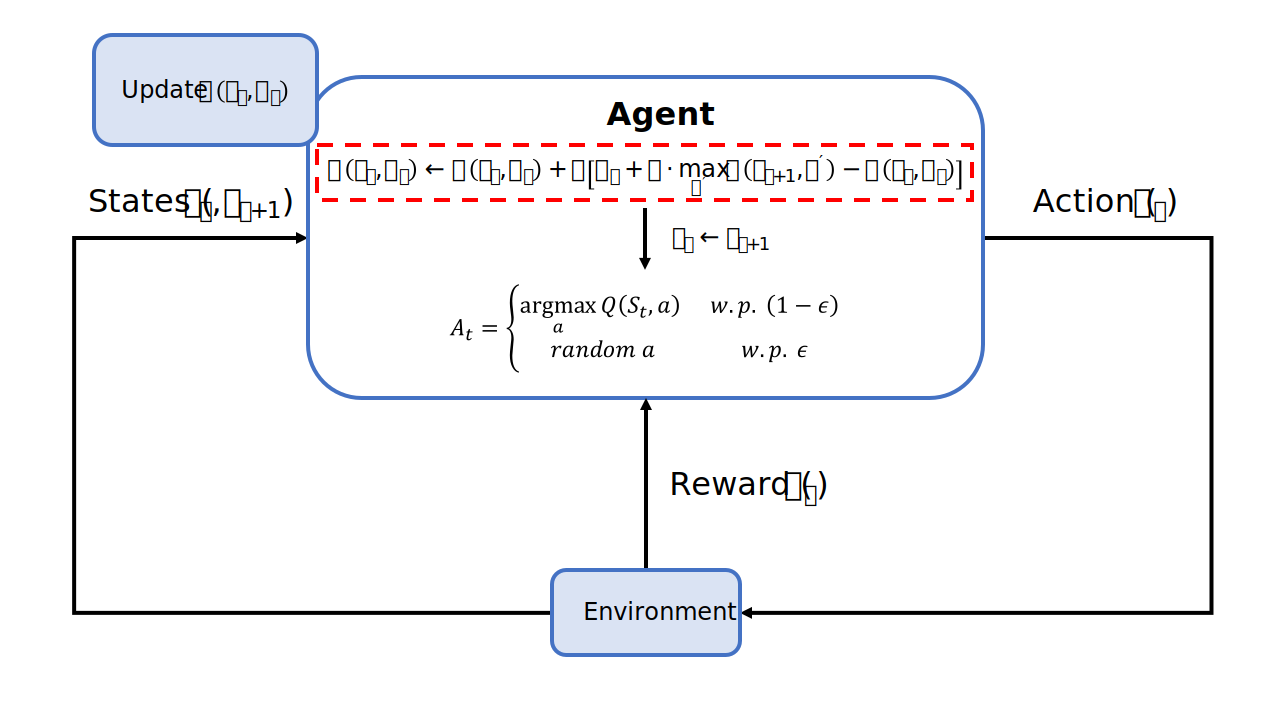

In [7]:
display(SVG(url="https://drive.google.com/uc?id=1n1rNgwsfQHIXMeivchSQGMye6QC4OlaN"))

Explain...

$$
Q(s, a) \leftarrow Q(s, a) + \alpha \cdot [R +  \gamma \cdot \underset{a'}{\mathrm{max}} Q(s', a') - Q(s, a)]
$$

Where:
- $Q(s, a)$ is ...
- $\alpha$ is ...
- $R$ is ...
- $\gamma$ is ...
- $s'$ is ...
- $a'$ is ...

## 1.3 Q-Learning for stock trading with 1 discrete technical indicator
---

### **Simplified discrete** stock trading problem with Q-Learning

Explain...

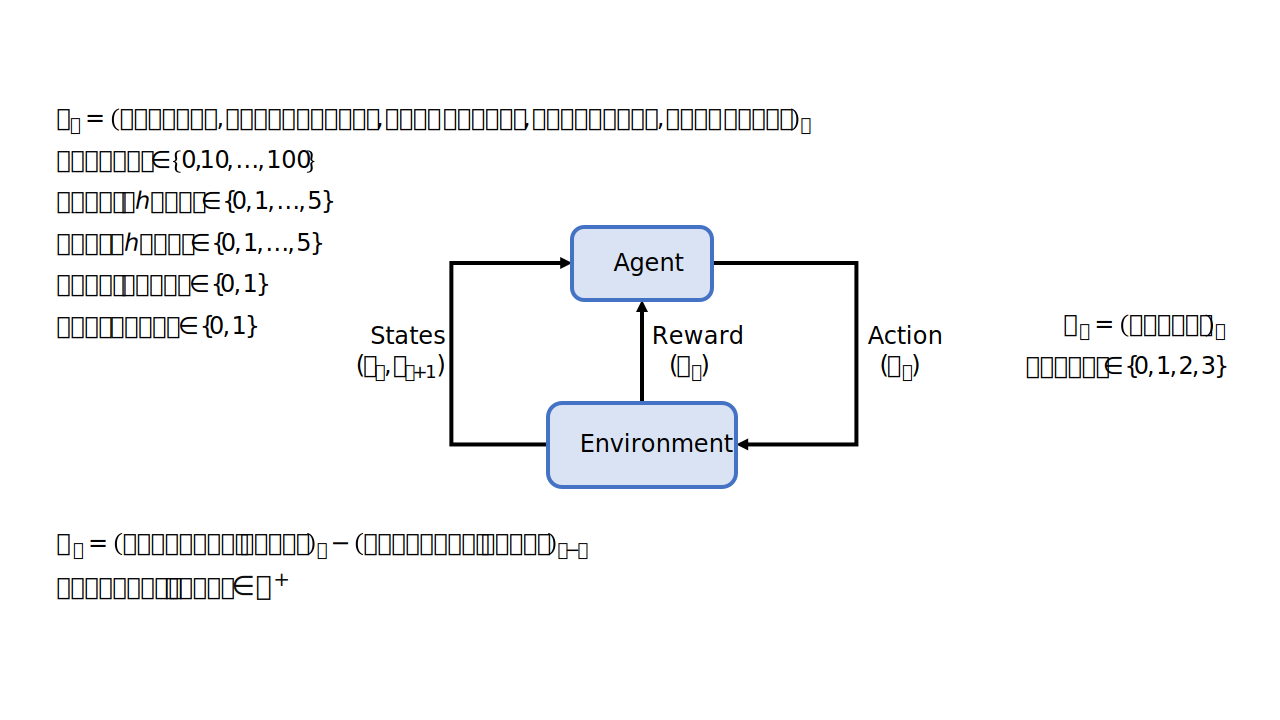

In [8]:
display(SVG(url="https://drive.google.com/uc?id=1WCiOcRt63nJ8cjUiHGt-IdcRLL29to8c"))

## 1.4 Experiment 1: **Simplified discrete** stock trading problem
---

In [4]:
class TradingEnvironment:
    """
    Our basic Environment Class, it implements all the common methods of MDP Environment
    """

    def __init__(
        self, pepsi_file: str, cola_file: str, observation_dim: int, action_dim: int
    ):
        self.observation_dim = observation_dim
        self.action_dim = action_dim
        self.pepsi_data = pd.read_csv(pepsi_file)
        self.pepsi_data.Name = "Pepsi"
        self.cola_data = pd.read_csv(cola_file)
        self.cola_data.Name = "Cola"

        self.action_space = range(action_dim)
        self.state = np.zeros(observation_dim)

        self.current_step = 0
        self.portfolio_value = self._compute_portfolio_value()

    def step(self, action: int) -> Tuple[np.ndarray, float, bool]:
        """
        Update the environment with action taken by the agent

        Args:
            action: int, The action taken by the agent

        Returns:
            state: np.ndarray, The next state
            reward: float, The reward returned by the environment
            done: bool, Is the episode terminated or truncated
        """
        self._check_action_validity(action)
        self.state = self._trade(action)
        self.current_step += 1
        done = self.current_step >= len(self.pepsi_data) - 1
        reward = self._compute_reward()

        return self.state, reward, done

    @abstractmethod
    def reset(self) -> np.ndarray:
        # Not Implemented
        raise NotImplementedError

    @abstractmethod
    def _trade(self, action: int) -> np.ndarray:
        # Not Implemented
        raise NotImplementedError

    @abstractmethod
    def _get_indicator(self, stock_data: pd.DataFrame) -> int | float:
        # Not Implemented
        raise NotImplementedError

    @abstractmethod
    def _check_action_validity(self, action: int) -> None:
        # Not Implemented
        raise NotImplementedError

    @abstractmethod
    def _compute_portfolio_value(self) -> float:
        # Not Implemented
        raise NotImplementedError

    def _get_stock_price(self, step: int, stock_data: pd.DataFrame) -> float:
        """
        Fetch the price for the given step and stock
        """
        return stock_data.iloc[step]["Close"]

    def _get_stock_trend(self, step: int, stock_data: pd.DataFrame) -> float:
        """
        Fetch the trend for the given stock between the given step and the previous one
        """
        return stock_data.iloc[step]["Close"] - stock_data.iloc[step - 1]["Close"]

    def _compute_reward(self) -> float:
        """
        Computes and updates the portfolio value and returns the reward associated
        The reward is the difference between the current portfolio value and the previous one
        """
        current_portfolio_value = self._compute_portfolio_value()
        reward = current_portfolio_value - self.portfolio_value
        self.portfolio_value = current_portfolio_value
        return reward

In [9]:
class SimplifiedDiscreteTradingEnvironment(TradingEnvironment):
    """
    The environment corresponding to the 1st experiment.

    State space = {0..10} x {0..5} x {0..5} x {0,1} x {0,1}
        representing respectively
            the remaining balance,
            the number of pepsi shares held,
            the number of cola shares held,
            the trend of pepsi stock,
            the trend of cola stock

    Action space = {0..3} for
        0: Sell all
        1: Hold
        2: Buy Pepsi
        3: Buy Cola

    The state is represented with an index in {0..1584} for Q-value tables
    """

    def __init__(self, pepsi_file: str, cola_file: str):
        self.observation_dim = (
            5  # [Balance, Shares Pepsi, Shares Cola, Trend Pepsi, Trend Cola]
        )
        self.action_dim = 4  # 0 = Sell all, 1 = Hold, 2 = Buy Pepsi, 3 = Buy Cola

        self.balance_unit = 10
        self.max_balance_units = 10
        self.max_shares_per_stock = 5

        self.max_state_index = (
            11 * 6 * 6 * 2 * 2
        )  # 11 balances, 6 shares each for Pepsi and Cola, 2 trends each

        super().__init__(pepsi_file, cola_file, self.observation_dim, self.action_dim)

        self.state = np.array(
            [15, 0, 0, 0, 0]
        )  # Initial state: [Balance, Pepsi shares, Cola shares, Trend of Pepsi, Trend of Cola]

    def __str__(self) -> str:
        info = """The environment is a Simplified Discrete Trading Problem (Experiment 1).\n 
        It is using the stocks: {}, {}
        The episode is at the timestep {}
        The current stock prices are {}$ and {}$
        Amount of shares held by the agent: {}
        Left balance: {}""".format(
            self.pepsi_data.Name,
            self.cola_data.Name,
            self.current_step,
            np.round(self._get_stock_price(self.current_step, self.pepsi_data), 2),
            np.round(self._get_stock_price(self.current_step, self.cola_data), 2),
            self.state[1:3],
            self.state[0],
        )

        return info

    def step(self, action: int) -> Tuple[int, float, bool]:
        """
        Update the environment with action taken by the agent

        Args:
            action: int, The action taken by the agent

        Returns:
            next_state_index: int, The index of the next state
            reward: float, The reward returned by the environment
            done: bool, Is the episode terminated or truncated
        """
        state, reward, done = super().step(action)
        state_index = self.convert_state_to_index(state)
        return state_index, reward, done

    def reset(self) -> np.ndarray:
        """
        Reset the environment to its initial State

        Returns:
            state: np.ndarray, The initial state
        """
        self.state = np.array([15, 0, 0, 0, 0])
        self.current_step = 0
        self.portfolio_value = self._compute_portfolio_value()
        return self.state

    def _trade(self, action: int) -> np.ndarray:
        """
        Trade the desired amount

        Args:
            action: int, The trade order, can be
                - 0: Sell all
                - 1: Hold
                - 2: Buy Pepsi
                - 3: Buy Cola

        Returns:
            state: np.ndarray, The state after the trade
        """
        balance_units, shares_pepsi, shares_cola = (
            self.state[0],
            self.state[1],
            self.state[2],
        )
        balance = balance_units * self.balance_unit
        pepsi_price = self._get_stock_price(self.current_step, self.pepsi_data)
        cola_price = self._get_stock_price(self.current_step, self.cola_data)

        if action == 0:  # Sell all
            balance += shares_pepsi * pepsi_price + shares_cola * cola_price
            shares_pepsi, shares_cola = 0, 0
        elif action == 2:  # Buy Pepsi
            quantity = min(
                balance // pepsi_price, self.max_shares_per_stock - shares_pepsi
            )
            shares_pepsi += quantity
            balance -= quantity * pepsi_price
        elif action == 3:  # Buy Cola
            quantity = min(
                balance // cola_price, self.max_shares_per_stock - shares_cola
            )
            shares_cola += quantity
            balance -= quantity * cola_price

        # Update state with rounded balance
        new_balance = min(int(balance / self.balance_unit), self.max_balance_units)

        trend_pepsi = self._get_indicator(self.current_step, self.pepsi_data)
        trend_cola = self._get_indicator(self.current_step, self.cola_data)

        return np.array(
            [new_balance, shares_pepsi, shares_cola, trend_pepsi, trend_cola]
        )

    def _get_indicator(self, step: int, stock_data: pd.DataFrame) -> int:
        """
        Compute the indicator used as observation. The

        Args:
            step: int, the current step of the episode
            stock_data: pd.DataFrame, the stock data from which one wants to get the indicator

        Returns
            indicator: int, The indicator giving the trend information (1 for rising, 0 for falling)
        """
        trend = self._get_stock_trend(step, stock_data)
        indicator = int(trend > 0)
        return indicator

    def _check_action_validity(self, action: int) -> None:
        """
        Ensures that parsed action is valid, raise an error if it is not
        """
        if action not in range(self.action_dim):
            raise ValueError("Action must be in [0,{}]".format(self.action_dim - 1))

    def _compute_portfolio_value(self) -> float:
        """
        Compute the current porfolio value
        """
        balance = self.state[0] * self.balance_unit
        pepsi_holdings_value = self.state[1] * self._get_stock_price(
            self.current_step, self.pepsi_data
        )
        cola_holdings_value = self.state[2] * self._get_stock_price(
            self.current_step, self.cola_data
        )
        return balance + pepsi_holdings_value + cola_holdings_value

    def convert_state_to_index(self, state: np.ndarray) -> int:
        balance_index, pepsi_shares, cola_shares, trend_pepsi, trend_cola = state
        index = balance_index
        index += pepsi_shares * 11
        index += cola_shares * 11 * 6
        index += trend_pepsi * 11 * 6 * 6
        index += trend_cola * 11 * 6 * 6 * 2
        return int(index)

    def convert_index_to_state(self, index: int) -> np.ndarray:
        trend_cola = index // (11 * 6 * 6 * 2)
        index %= 11 * 6 * 6 * 2
        trend_pepsi = index // (11 * 6 * 6)
        index %= 11 * 6 * 6
        cola_shares = index // (11 * 6)
        index %= 11 * 6
        pepsi_shares = index // 11
        balance_index = index % 11
        return np.array(
            [balance_index, pepsi_shares, cola_shares, trend_pepsi, trend_cola]
        )

In [10]:
class QLearningAgent:
    """
    The class implementing our agent for Experiment 1
    """

    def __init__(
        self,
        state_space: int,
        action_space: int,
        learning_rate=0.01,
        discount_factor=0.99,
        exploration_rate=1.0,
    ):
        # Env
        self.state_space = state_space
        self.max_state_index = 11 * 6 * 6 * 2 * 2
        self.action_space = action_space

        # Learning
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.exploration_rate = exploration_rate
        self.exploration_min = 0.01
        self.exploration_decay = 0.995
        self.q_table = np.zeros((self.max_state_index, action_space))

        # Monitoring
        self.q_table_history = np.zeros((1, self.max_state_index, action_space))

    def __str__(self) -> str:
        info = """The agent is using Q-Learning algorithm\n
        It is working on Simplified Discrete Trading Environment (Experiment 1)\n
        The current Q Table values can be fetch by calling get_current_q_values() method\n
        The history of Q Table values can be fetch by calling get_history_q_values() method"""
        return info

    def choose_action(self, state_index: int) -> int:
        """
        Choose action according to current Q Table

        Args:
            state_index: int, The index corresponding to the state in which the environment is in

        Returns:
            action: int, The action picked according to the current Q-values
        """
        if np.random.rand() < self.exploration_rate:
            return random.randrange(self.action_space)
        return np.argmax(self.q_table[state_index])

    def train(
        self, state_index: int, action: int, reward: float, next_state_index: int
    ) -> None:
        """
        Update Q values following Q Learning classical update

        Args:
            state_index: int, The index corresponding to the state in which the environment was before taking the action
            action: int, The action picked by the agent
            reward: float, The reward that was returned by the environment after the agent took the action
            next_state_index: int, The index corresponding to the state in which the environment is after taking the action
        """
        assert 0 <= state_index < self.max_state_index, "Invalid state_index"
        assert 0 <= next_state_index < self.max_state_index, "Invalid next_state_index"

        q_value = self.q_table[state_index, action]

        # Target = Rt + Gamma x max(Q[S(t+1), a])
        target = reward + self.discount_factor * np.max(self.q_table[next_state_index])

        # Q[S(t), action] =  Q[S(t), action] + alpha x (Rt + Gamma x max(Q[S(t+1), a]) - Q[S(t), action])
        self.q_table[state_index, action] += self.learning_rate * (target - q_value)

        # Store Q table
        self.q_table_history = np.concatenate((self.q_table_history, [self.q_table]))

        self.exploration_rate = max(
            self.exploration_rate * self.exploration_decay, self.exploration_min
        )

    def get_current_q_values(self) -> np.ndarray:
        """
        Fetch the current Q Table as a numpy array of shape:
            (number of possible states, number of possible actions)
        """
        return self.q_table

    def get_history_q_values(self) -> np.ndarray:
        """
        Fetch the history of Q Tables as a numpy array of shape:
            (number of episodes seen, number of possible states, number of possible actions)
        """
        return self.q_table_history

In [11]:
def train_QLearning_agent(
    env: SimplifiedDiscreteTradingEnvironment, agent: QLearningAgent, num_episodes: int
):
    """
    Performs the training of the Agent for experiment 1
    """

    rewards_per_episode = []
    q_values_array = np.zeros((num_episodes, 11, 6, 6, 2, 2, 4)) 

    for episode in range(num_episodes):
        state_index = env.reset()  # Get the initial state index
        total_rewards = 0

        done = False
        while not done:
            action = agent.choose_action(state_index)
            next_state_index, reward, done = env.step(action)  # next_state_index is directly obtained here
            agent.learn(state_index, action, reward, next_state_index)

            state_ = env.convert_index_to_state(state_index)
            q_values_array[episode, 
                           state_[0], state_[1], state_[2], state_[3], state_[4], 
                           action] = agent.q_table[state_index, action]

            state_index = next_state_index
            total_rewards += reward

        rewards_per_episode.append(total_rewards)
        print(f"Episode: {episode}, Total Reward: {total_rewards}")

    plt.plot(rewards_per_episode)
    plt.title('Rewards per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.show()

    return rewards_per_episode, q_values_array

In [12]:
EnvExp1 = SimplifiedDiscreteTradingEnvironment("pepsi_data.csv", "cola_data.csv")
AgentExp1 = QLearningAgent(state_space=5, action_space=4)
rewards = train_QLearning_agent(env=EnvExp1, agent=AgentExp1, num_episodes=1000)

In [ ]:
_, q_values_array = rewards
q_values_array

## 1.5 Experiment 1 results
---

### Performance

Plot and analyse results...

### Learned Q-values

Display leanred Q-value table and gain insight...

# Part 2. **Simplified continuous** stock trading problem
---
---

Explain...

## 2.1 Function approximation
---

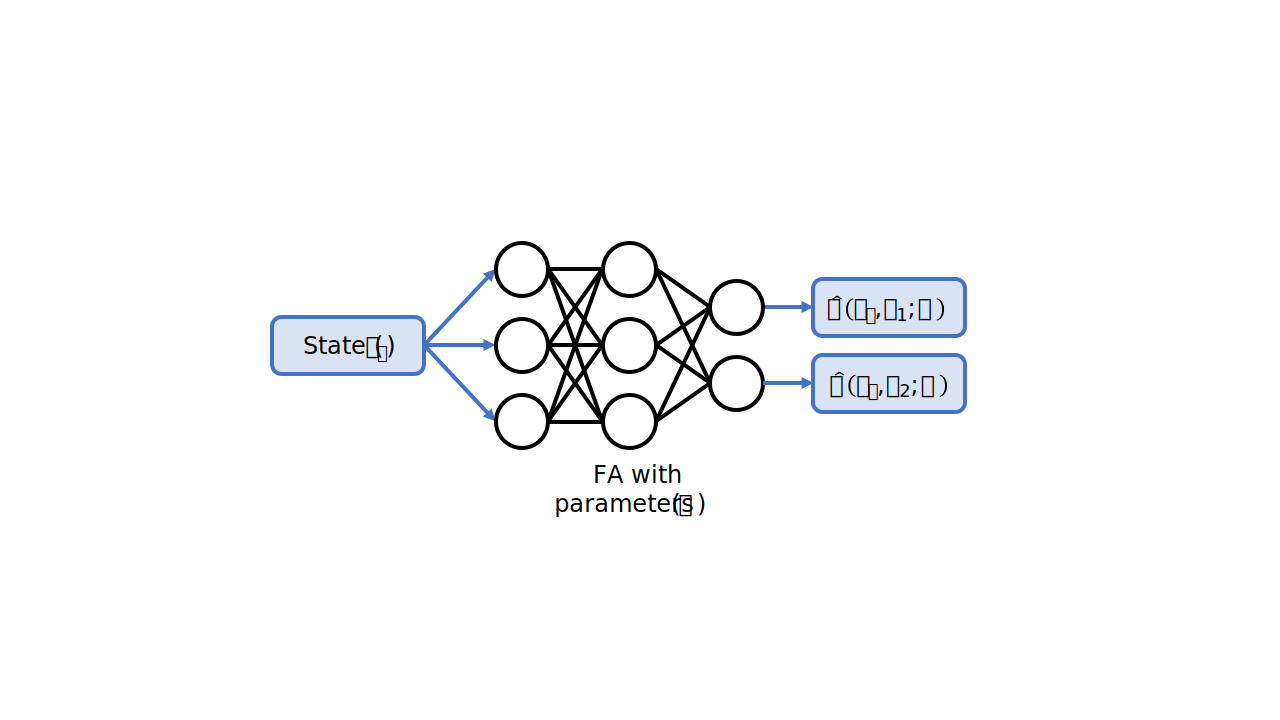

In [9]:
display(SVG(url="https://drive.google.com/uc?id=1oxtTZ6LkqGDSfdf0_wN2DSSjle3W-7VA"))

Explain...

## 2.2 Deep Q-Learning
---

Deep Q-Learning introduction...

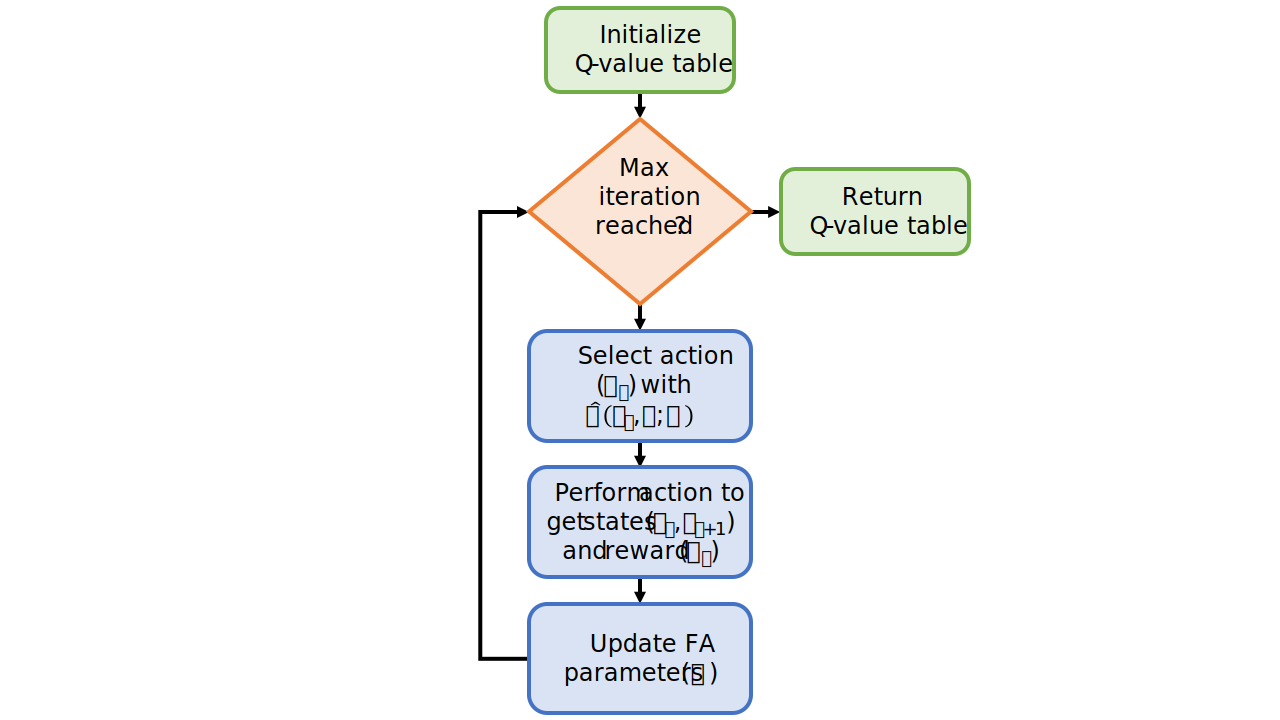

In [10]:
display(SVG(url="https://drive.google.com/uc?id=1XtgSnYa7Whne9FrQH_IJcmiFfwVW02Yp"))

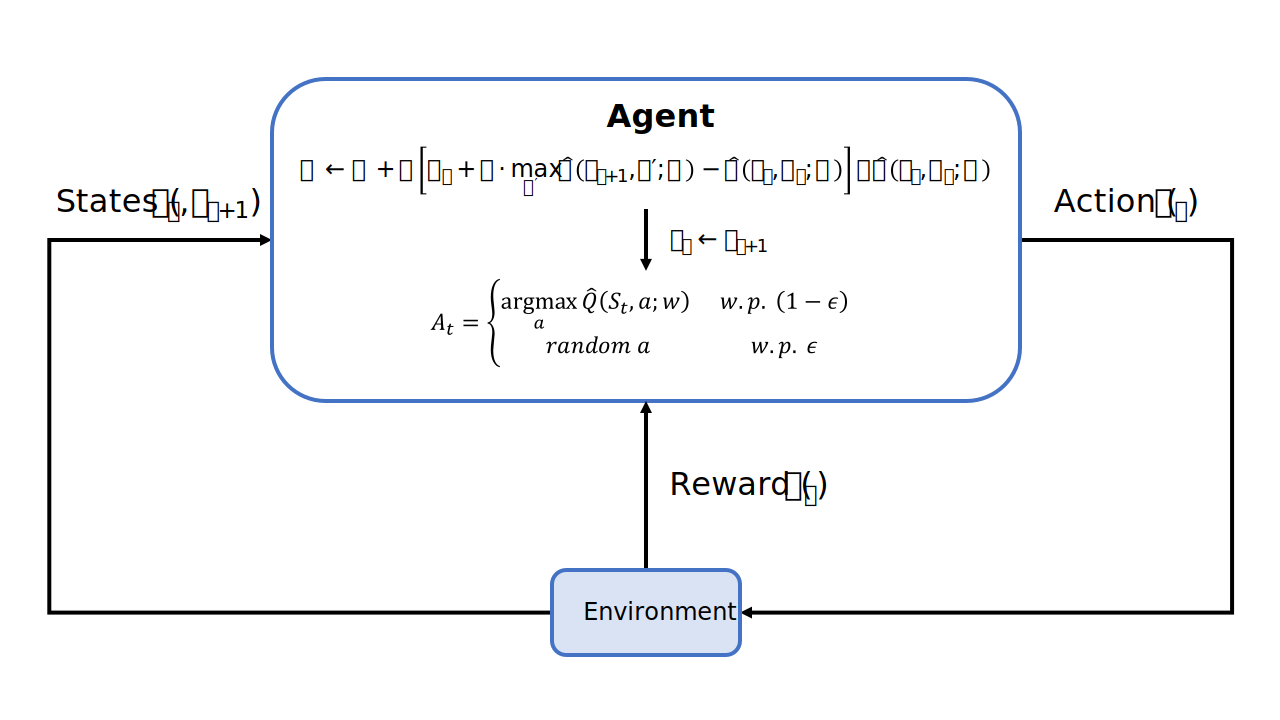

In [11]:
display(SVG(url="https://drive.google.com/uc?id=1-F-omld3WPjQPmKLo-MSeWRUwYgb1qc0"))

### Select an action ($A_{t}$) with $\hat{Q}(S_{t}, a; w)$

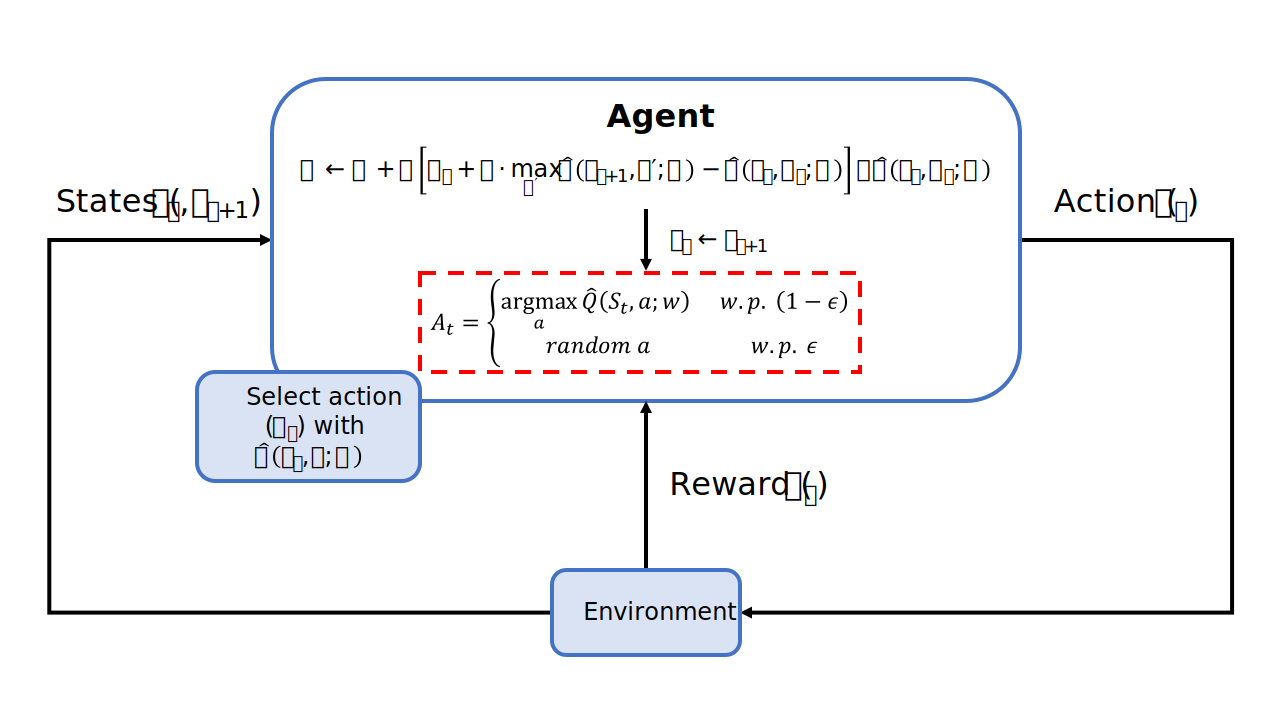

In [12]:
display(SVG(url="https://drive.google.com/uc?id=1h_o7S6YSS6_HhRdtABXRJB3IIT0UMpPA"))

### Update FA parameters ($w$)

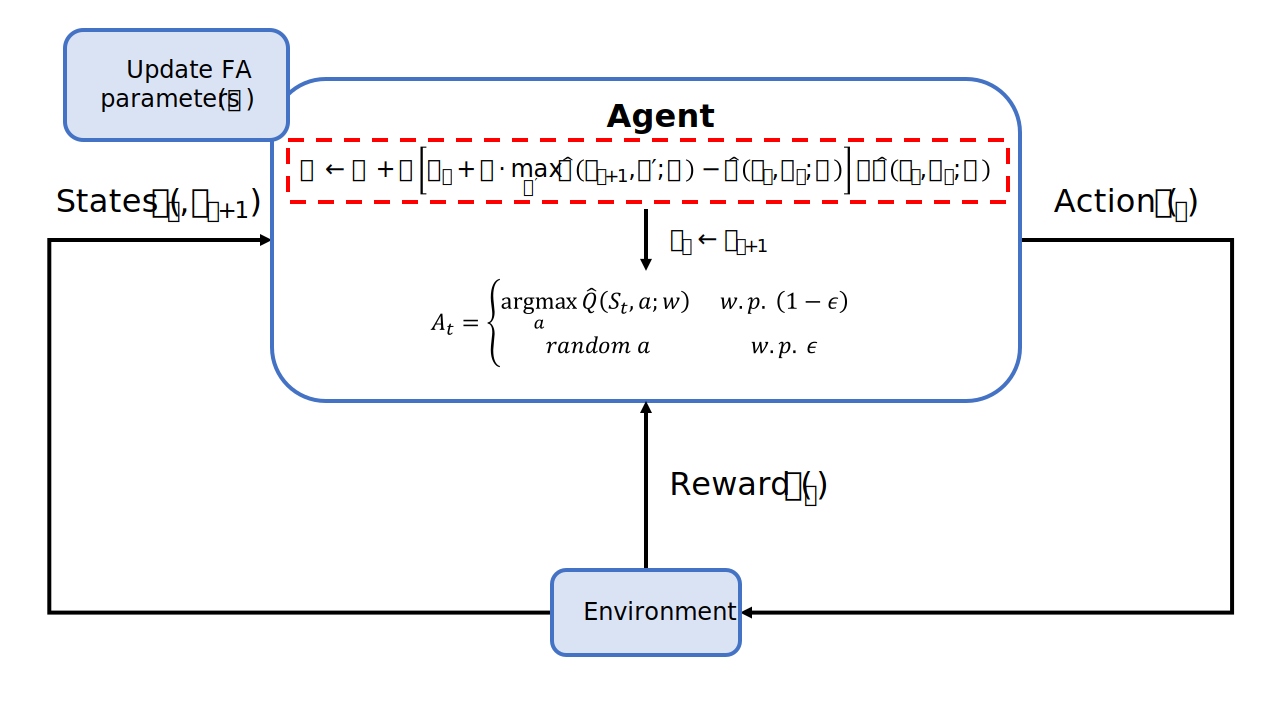

In [13]:
display(SVG(url="https://drive.google.com/uc?id=14eqczRrPlBxd7NGBggcNZnHrdaON6S79"))

## 2.3 Deep Q-Learning for stock trading with 1 continuous technical indicator
---

### **Simplified continuous** stock trading problem with deep Q-Learning

Explain...

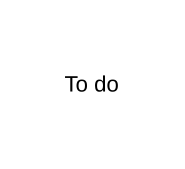

In [14]:
display(SVG(url="https://drive.google.com/uc?id=1lVKdS06Sc9lCtW_P3Ek48gTYdJfvfRz-"))

## 2.4 Experiment 2: **Simplified continuous** stock trading problem
---

## 2.5 Experiment 2 results
---

### Performance

Plot and analyse results...

### Learned Q-values

Display leanred Q-value surface and gain insight...

# Part 3. **Complete continuous** stock trading problem
---
---

Explain...

## 3.1 Deep Q-Learning for stock trading with multiple continuous technical indicators
---

### **Complete continuous** stock trading problem with deep Q-Learning

Explain...

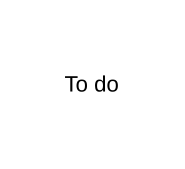

In [15]:
display(SVG(url="https://drive.google.com/uc?id=1lVKdS06Sc9lCtW_P3Ek48gTYdJfvfRz-"))

## 3.2 Experiment 3: **Complete continuous** stock trading problem
---

## 3.3 Experiment 3 results
---

### Performance

Plot and analyse results...

### Learned Q-values

Display leanred Q-value surface and gain insight...

# Conclusions
---
---

Explain...